# Light Enhancement

In [144]:
!git clone https://github.com/wangchx67/SYSU-FVL-T2.git

Cloning into 'SYSU-FVL-T2'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 130 (delta 36), reused 89 (delta 9), pack-reused 0
Receiving objects: 100% (130/130), 38.15 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [147]:
!pip install einops gdown addict future lmdb numpy pyyaml requests scipy tb-nightly yapf lpips

DEPRECATION: Loading egg at /opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools-70.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00


In [176]:
!ls

Options              evaluate_PSNR_SSIM.m test.py
__pycache__          pretrained_models    utils.py


In [202]:
! pip install --use-pep517

ERROR: You must give at least one requirement to install (see "pip help install")


In [150]:
%cd SYSU-FVL-T2
!python setup.py develop --no_cuda_ext

/Users/betterhalf/Desktop/image enhancement/SYSU-FVL-T2
/opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools/__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools/command/develop.py:42: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

In [203]:
%cd Enhancement
!python test.py --input_dir /Users/betterhalf/Desktop/image enhancement/demo/sample_images/super_resolution/enhanced --result_dir /Users/betterhalf/Desktop/image enhancement/demo/sample_images/Motion_Deblurring/Low_Light_Enhancement

[Errno 2] No such file or directory: 'Enhancement'
/Users/betterhalf/Desktop/image enhancement
python: can't open file '/Users/betterhalf/Desktop/image enhancement/test.py': [Errno 2] No such file or directory


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
img_imput = plt.imread('/kaggle/input/modified/g.png')
plt.imshow(img_imput)

plt.subplot(1,2,2)
img = plt.imread('/kaggle/working/SYSU-FVL-T2/Enhancement/results/NtireLL/g.png')
plt.imshow(img)

In [179]:
%cd ..

/Users/betterhalf/Desktop/image enhancement


In [201]:
!ls

4BSRGAN.png                         demo
Denoising                           low_light
Motion_Deblurring-pretrained_models modified_low_light
Restormer                           pic
SYSU-FVL-T2                         png2jpg
Super-Resolution                    ref.jpg
Untitled.ipynb                      requirements.txt
color_correction.py                 results
color_correction_trail.py           test.jpg



# Denoising

In [181]:
task_1 = 'Real_Denoising'
task_2 = 'Motion_Deblurring'

In [182]:
import torch

In [183]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()

device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [184]:
import os
import shutil
# from google.colab import files

# Download sample images
# !rm -r demo/*
# !wget https://github.com/swz30/Restormer/releases/download/v1.0/sample_images.zip -P demo
# shutil.unpack_archive('demo/sample_images.zip', 'demo/')
# os.remove('demo/sample_images.zip')

# OR Uncomment the following block if you would like to upload your own images. 

# !rm -r demo/*

folder_path = '/Users/betterhalf/Desktop/Experiment/pic_filters/maxim-tf/images/Denoising/input'


# 4. Prepare Model and Load Checkpoint

In [185]:
import os

x = os.listdir(folder_path)
for i in x:
    if i == '.DS_Store':
        os.remove(os.path.join(folder_path, i))


In [186]:
x = os.listdir(folder_path)
for i in x:
    print(i)

0039_04.png
0003_30.png
0011_23.png
0013_19.png


In [187]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from runpy import run_path
from skimage import img_as_ubyte
from natsort import natsorted
from glob import glob
import cv2
from tqdm import tqdm
import argparse
import numpy as np

def get_weights_and_parameters(task, parameters):
    if task == 'Motion_Deblurring':
        weights = os.path.join('Motion_Deblurring-pretrained_models', 'motion_deblurring.pth')
    elif task == 'Single_Image_Defocus_Deblurring':
        weights = os.path.join('Defocus_Deblurring', 'pretrained_models', 'single_image_defocus_deblurring.pth')
    elif task == 'Deraining':
        weights = os.path.join('Deraining', 'pretrained_models', 'deraining.pth')
    elif task == 'Real_Denoising':
        weights = os.path.join('Denoising', 'pretrained_models', 'real_denoising.pth')
        parameters['LayerNorm_type'] =  'BiasFree'
    return weights, parameters


# Get model weights and parameters
parameters = {'inp_channels':3, 'out_channels':3, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'WithBias', 'dual_pixel_task':False}
weights, parameters = get_weights_and_parameters(task_1, parameters)

load_arch = run_path(os.path.join('Restormer', 'basicsr', 'models', 'archs', 'restormer_arch.py'))
model = load_arch['Restormer'](**parameters)
# model.cuda()

checkpoint = torch.load(weights)
model.load_state_dict(checkpoint['params'])
model.eval()

Restormer(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=254, bias=False)
        (project_out): Conv2d(127, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBlock(
 

In [188]:
input_dir = 'demo/sample_images/'+task_1+'/degraded'
out_dir = 'demo/sample_images/'+task_2+'/degraded'
os.makedirs(out_dir, exist_ok=True)
extensions = ['jpg', 'JPG', 'png', 'PNG', 'jpeg', 'JPEG', 'bmp', 'BMP']
files = natsorted(glob(os.path.join(input_dir, '*')))

img_multiple_of = 8

print(f"\n ==> Running {task_1} with weights {weights}\n ")
with torch.no_grad():
  for filepath in tqdm(files):
      # print(file_)
      # torch.device.ipc_collect()
      # torch.device.empty_cache()
      img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
      input_ = torch.from_numpy(img).float().div(255.).permute(2,0,1).unsqueeze(0)

      # Pad the input if not_multiple_of 8
      h,w = input_.shape[2], input_.shape[3]
      H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
      padh = H-h if h%img_multiple_of!=0 else 0
      padw = W-w if w%img_multiple_of!=0 else 0
      input_ = F.pad(input_, (0,padw,0,padh), 'reflect')

      restored = model(input_)
      restored = torch.clamp(restored, 0, 1)

      # Unpad the output
      restored = restored[:,:,:h,:w]

      restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
      restored = img_as_ubyte(restored[0])

      filename = os.path.split(filepath)[-1]
      cv2.imwrite(os.path.join(out_dir, filename),cv2.cvtColor(restored, cv2.COLOR_RGB2BGR))


 ==> Running Real_Denoising with weights Denoising/pretrained_models/real_denoising.pth
 


100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


Results: Real_Denoising


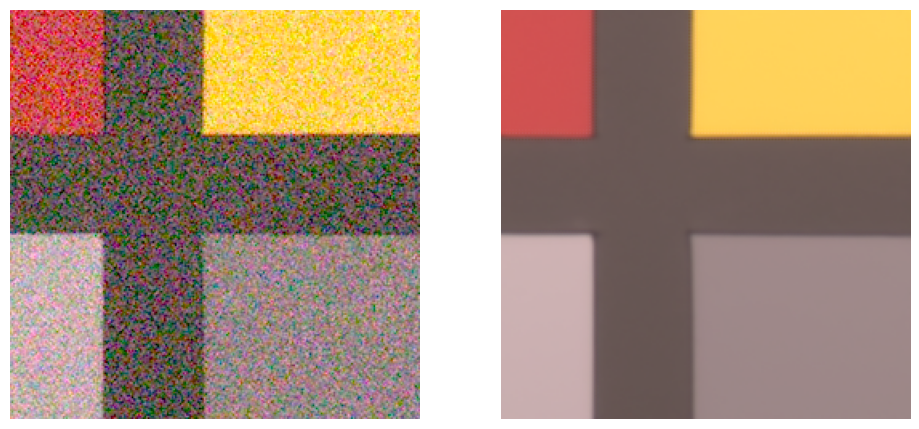

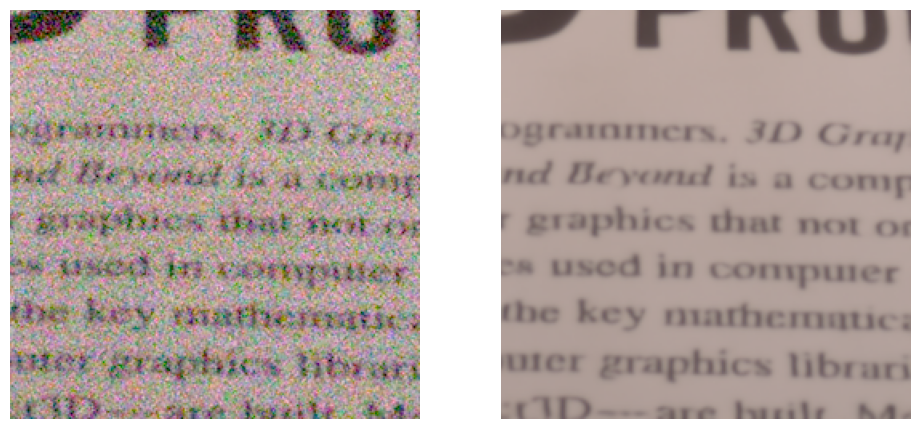

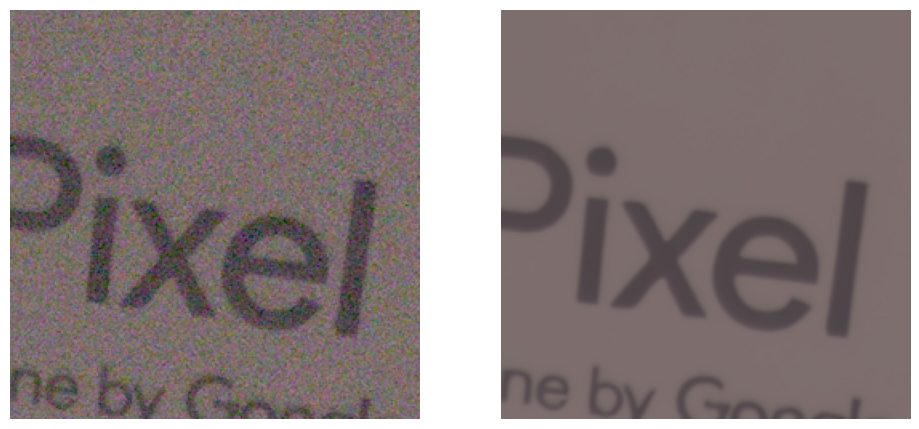

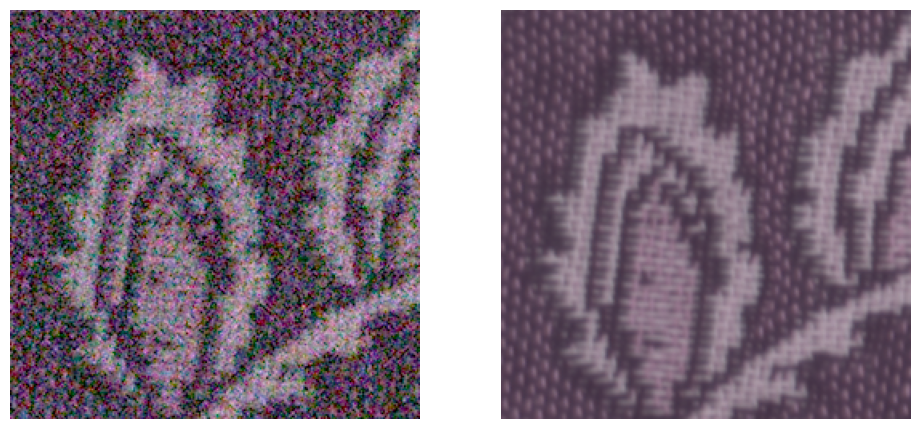

In [189]:
import matplotlib.pyplot as plt
inp_filenames = natsorted(glob(os.path.join(input_dir, '*')))
out_filenames = natsorted(glob(os.path.join(out_dir, '*')))

## Will display only first 5 images
num_display_images = 5
if len(inp_filenames)>num_display_images:
  inp_filenames = inp_filenames[:num_display_images]
  out_filenames = out_filenames[:num_display_images]

print(f"Results: {task_1}")
for inp_file, out_file in zip(inp_filenames, out_filenames):
  degraded = cv2.cvtColor(cv2.imread(inp_file), cv2.COLOR_BGR2RGB)
  restored = cv2.cvtColor(cv2.imread(out_file), cv2.COLOR_BGR2RGB)
  ## Display Images
  fig, axes = plt.subplots(nrows=1, ncols=2)
  dpi = fig.get_dpi()
  fig.set_size_inches(900/ dpi, 448 / dpi)
  plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
  axes[0].axis('off')
  axes[0].imshow(degraded)
  axes[1].axis('off')
  axes[1].imshow(restored)
  plt.show()

# Image Deblurring

In [190]:
# Get model weights and parameters
parameters = {'inp_channels':3, 'out_channels':3, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'WithBias', 'dual_pixel_task':False}
weights, parameters = get_weights_and_parameters(task_2, parameters)

load_arch = run_path(os.path.join('Restormer', 'basicsr', 'models', 'archs', 'restormer_arch.py'))
model = load_arch['Restormer'](**parameters)
# model.cuda()

checkpoint = torch.load(weights)
model.load_state_dict(checkpoint['params'])
model.eval()

Restormer(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=254, bias=False)
        (project_out): Conv2d(127, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBlock(
 

In [191]:
task_2

'Motion_Deblurring'

In [192]:
input_dir = 'demo/sample_images/'+task_2+'/degraded'
out_dir = 'demo/sample_images/'+task_2+'/restored'
os.makedirs(out_dir, exist_ok=True)
extensions = ['jpg', 'JPG', 'png', 'PNG', 'jpeg', 'JPEG', 'bmp', 'BMP']
files = natsorted(glob(os.path.join(input_dir, '*')))

img_multiple_of = 8

print(f"\n ==> Running {task_2} with weights {weights}\n ")
with torch.no_grad():
  for filepath in tqdm(files):
      # print(file_)
      # torch.device.ipc_collect()
      # torch.device.empty_cache()
      img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
      input_ = torch.from_numpy(img).float().div(255.).permute(2,0,1).unsqueeze(0)

      # Pad the input if not_multiple_of 8
      h,w = input_.shape[2], input_.shape[3]
      H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
      padh = H-h if h%img_multiple_of!=0 else 0
      padw = W-w if w%img_multiple_of!=0 else 0
      input_ = F.pad(input_, (0,padw,0,padh), 'reflect')

      restored = model(input_)
      restored = torch.clamp(restored, 0, 1)

      # Unpad the output
      restored = restored[:,:,:h,:w]

      restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
      restored = img_as_ubyte(restored[0])

      filename = os.path.split(filepath)[-1]
      cv2.imwrite(os.path.join(out_dir, filename),cv2.cvtColor(restored, cv2.COLOR_RGB2BGR))


 ==> Running Motion_Deblurring with weights Motion_Deblurring-pretrained_models/motion_deblurring.pth
 


100%|██████████| 4/4 [00:19<00:00,  4.80s/it]


Results: Motion_Deblurring


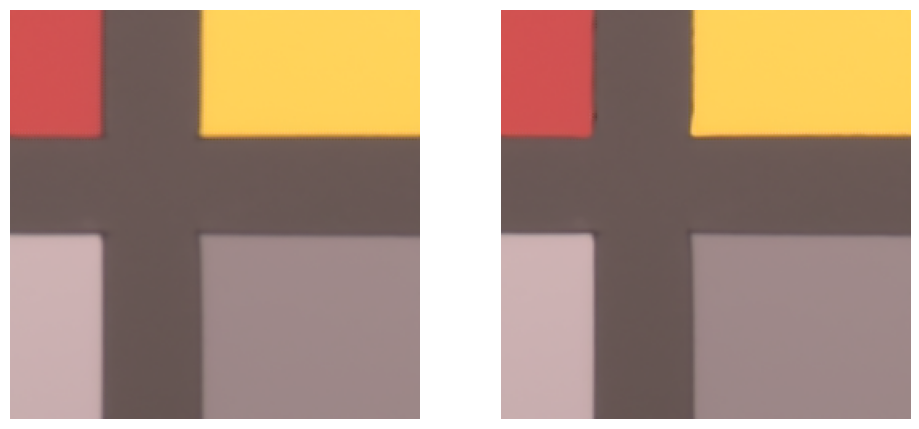

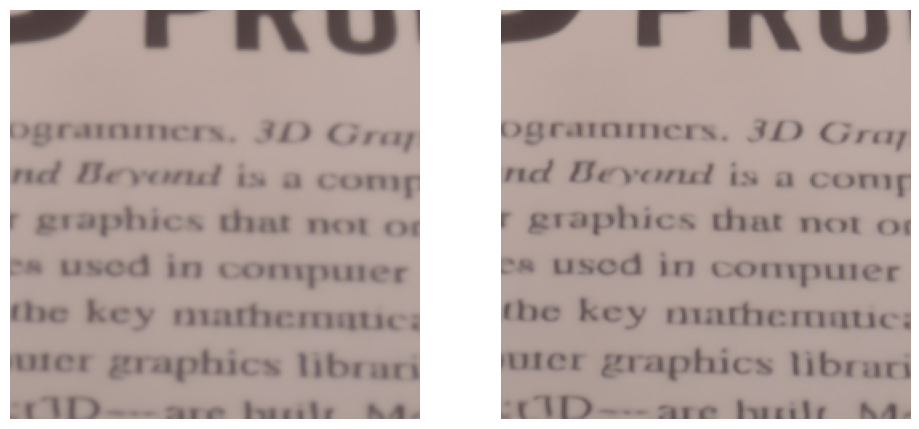

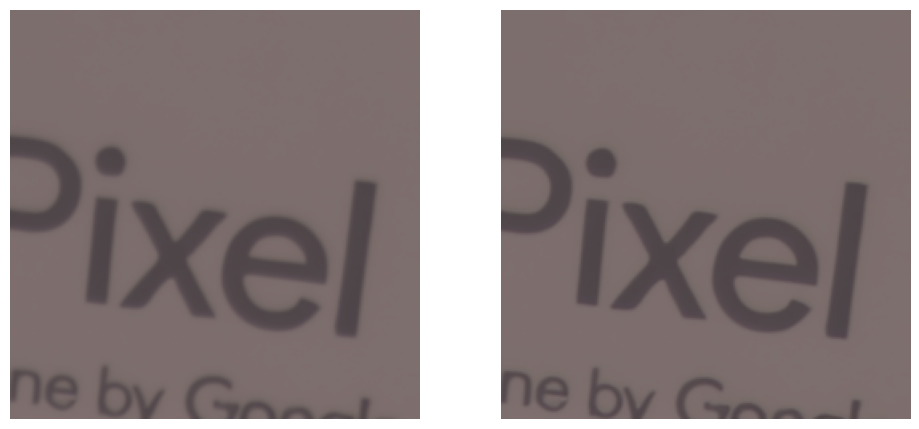

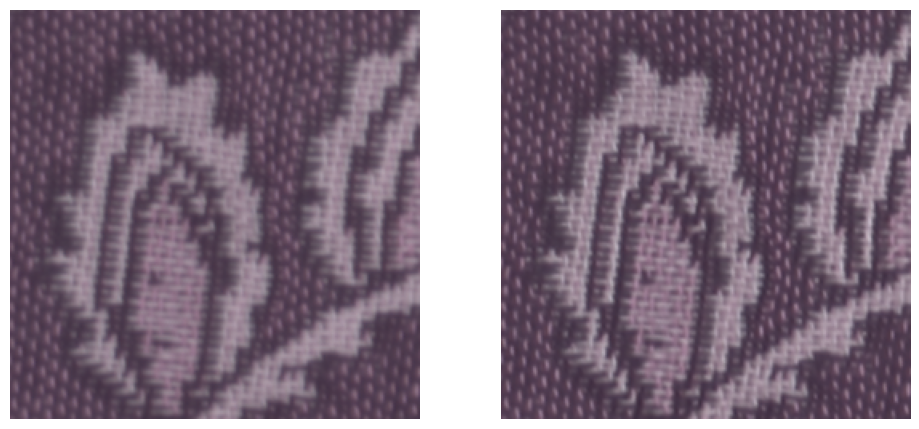

In [193]:
import matplotlib.pyplot as plt
inp_filenames = natsorted(glob(os.path.join(input_dir, '*')))
out_filenames = natsorted(glob(os.path.join(out_dir, '*')))

## Will display only first 5 images
num_display_images = 5
if len(inp_filenames)>num_display_images:
  inp_filenames = inp_filenames[:num_display_images]
  out_filenames = out_filenames[:num_display_images]

print(f"Results: {task_2}")
for inp_file, out_file in zip(inp_filenames, out_filenames):
  degraded = cv2.cvtColor(cv2.imread(inp_file), cv2.COLOR_BGR2RGB)
  restored = cv2.cvtColor(cv2.imread(out_file), cv2.COLOR_BGR2RGB)
  ## Display Images
  fig, axes = plt.subplots(nrows=1, ncols=2)
  dpi = fig.get_dpi()
  fig.set_size_inches(900/ dpi, 448 / dpi)
  plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
  axes[0].axis('off')
  axes[0].imshow(degraded)
  axes[1].axis('off')
  axes[1].imshow(restored)
  plt.show()

# Image Super Resolution

In [194]:
task_3 = 'super_resolution'

In [195]:
!ls

4BSRGAN.png                         demo
Denoising                           low_light
Motion_Deblurring-pretrained_models modified_low_light
Restormer                           pic
SYSU-FVL-T2                         png2jpg
Super-Resolution                    ref.jpg
Untitled.ipynb                      requirements.txt
color_correction.py                 results
color_correction_trail.py           test.jpg


In [196]:
!ls

4BSRGAN.png                         demo
Denoising                           low_light
Motion_Deblurring-pretrained_models modified_low_light
Restormer                           pic
SYSU-FVL-T2                         png2jpg
Super-Resolution                    ref.jpg
Untitled.ipynb                      requirements.txt
color_correction.py                 results
color_correction_trail.py           test.jpg


In [197]:
from bsrgan import BSRGAN

model = BSRGAN(model_path='kadirnar/bsrgan',device='cpu', hf_model=True)
model.save = True

file_path = 'demo/sample_images/Motion_Deblurring/restored'

files = natsorted(glob(os.path.join(file_path, '*')))


# pred = model.predict(img_path='/content/0011_23.png')

[3, 3, 64, 23, 32, 4]


In [198]:
!pip install pillow

DEPRECATION: Loading egg at /opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools-70.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [199]:
from PIL import Image
import os
from tqdm import tqdm

output_folder = 'demo/sample_images/' + task_3 + '/enhanced'
i = 1

for filepath in tqdm(files):
    pred = model.predict(filepath)
    
    # Assuming pred is a path to the PNG file
    if isinstance(pred, str) and pred.endswith('.png'):
        # Open the predicted image using PIL
        pred_image = Image.open(pred)
    
        # Define the output filename
        output_filename = str(i) + 'BSRGAN.png'
        i += 1
    
        # Create the output folder if it does not exist
        os.makedirs(output_folder, exist_ok=True)
    
        # Save the image to the specified folder
        pred_image.save(os.path.join(output_folder, output_filename))
    else:
        raise ValueError("The prediction output is not a valid PNG file path.")


100%|██████████| 4/4 [01:38<00:00, 24.71s/it]


Results: Motion_Deblurring


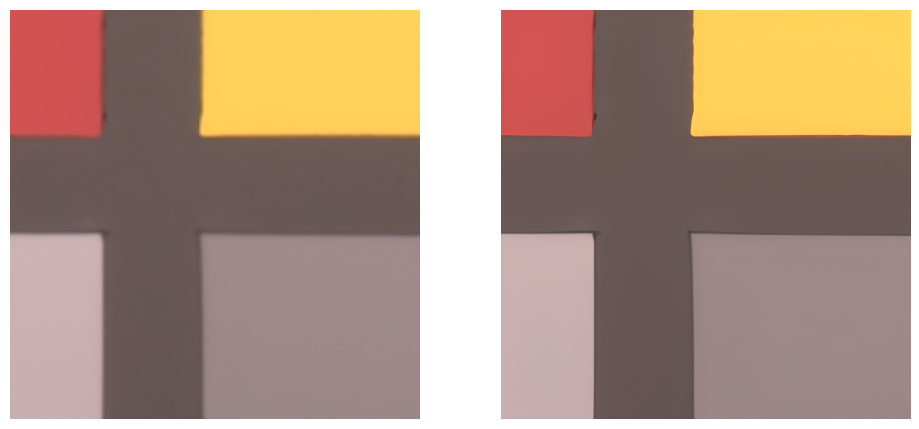

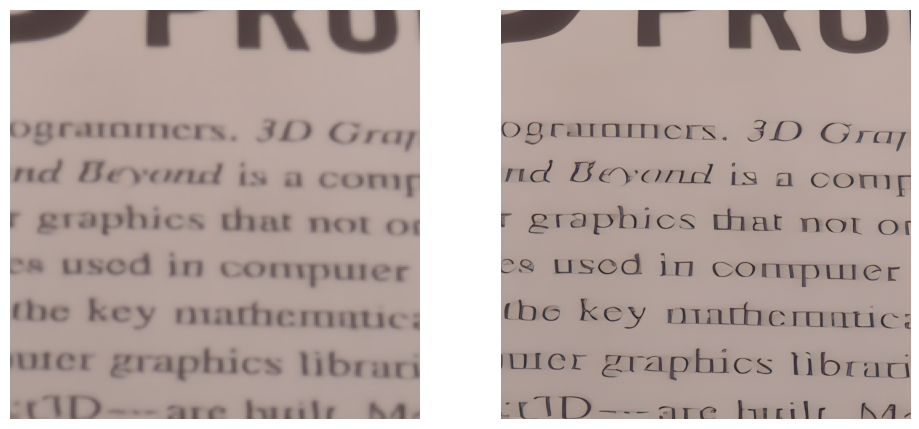

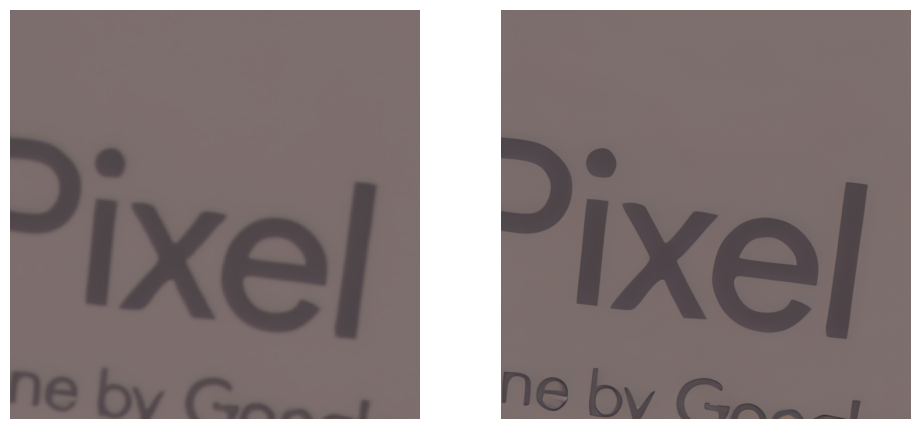

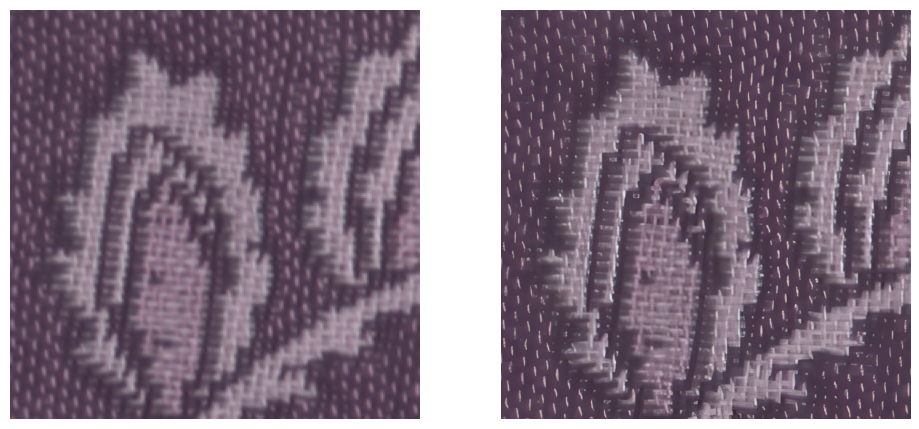

In [200]:
import matplotlib.pyplot as plt
inp_filenames = natsorted(glob(os.path.join(file_path, '*')))
out_filenames = natsorted(glob(os.path.join(output_folder, '*')))

## Will display only first 5 images
num_display_images = 5
if len(inp_filenames)>num_display_images:
  inp_filenames = inp_filenames[:num_display_images]
  out_filenames = out_filenames[:num_display_images]

print(f"Results: {task_2}")
for inp_file, out_file in zip(inp_filenames, out_filenames):
  degraded = cv2.cvtColor(cv2.imread(inp_file), cv2.COLOR_BGR2RGB)
  restored = cv2.cvtColor(cv2.imread(out_file), cv2.COLOR_BGR2RGB)
  ## Display Images
  fig, axes = plt.subplots(nrows=1, ncols=2)
  dpi = fig.get_dpi()
  fig.set_size_inches(900/ dpi, 448 / dpi)
  plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
  axes[0].axis('off')
  axes[0].imshow(degraded)
  axes[1].axis('off')
  axes[1].imshow(restored)
  plt.show()

# Color Enhancement

In [104]:
! pip install imutils==0.5.4


DEPRECATION: Loading egg at /opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools-70.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=877f27a52f9754910ab10716093fa7aa426c2940a11e1413fc108831f10a4ab3
  Stored in directory: /Users/betterhalf/Library/Caches/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


In [105]:
!pip install opencv-contrib-python

DEPRECATION: Loading egg at /opt/anaconda3/envs/torch/lib/python3.11/site-packages/setuptools-70.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 19.2 MB/s eta 0:00:0000:0100:01


In [143]:
!python color_correction_trail.py --reference ref.jpg --input png2jpg/4BSRGAN.jpg

[INFO] loading images...
[INFO] finding color matching cards...
image_card
refCard
dwawdadwada
[INFO] could not find color matching card in both images


In [114]:
!ls

Denoising                           demo
Motion_Deblurring-pretrained_models low_light
Restormer                           modified_low_light
Super-Resolution                    pic
Untitled.ipynb                      ref.jpg
color_correction.py                 requirements.txt
color_correction_trail.py           results
